In [34]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import transformers as trf
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, confusion_matrix, f1_score,
    precision_score, recall_score)
from sklearn.model_selection import  train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from torch.utils.data import DataLoader, TensorDataset


warnings.filterwarnings('ignore')
batch_size = 8

In [2]:
bbc_df = pd.read_csv('../data/bbc_data.csv')
bbc_df

,data,labels
0,Musicians to tackle US red tape Musicians gro...,entertainment
1,"U2s desire to be number one U2, who have won ...",entertainment
2,Rocker Doherty in on-stage fight Rock singer ...,entertainment
3,Snicket tops US box office chart The film ada...,entertainment
4,"Oceans Twelve raids box office Oceans Twelve,...",entertainment
...,...,...
2220,Warning over Windows Word files Writing a Mic...,tech
2221,Fast lifts rise into record books Two high-sp...,tech
2222,Nintendo adds media playing to DS Nintendo is...,tech
2223,Fast moving phone viruses appear Security fir...,tech


In [5]:
# For DistilBERT:
model_class, tokenizer_class, pretrained_weights = (trf.DistilBertModel, trf.DistilBertTokenizer, 'distilbert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

In [16]:
# Tokenize with DistilBERT
tokenized = bbc_df["data"].apply((lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=512, truncation=True)))
tokenized

0       [101, 5389, 2000, 11147, 2149, 2417, 6823, 538...
1       [101, 23343, 2015, 4792, 2000, 2022, 2193, 202...
2       [101, 24779, 23798, 1999, 2006, 1011, 2754, 29...
3       [101, 1055, 13542, 3388, 13284, 2149, 3482, 24...
4       [101, 17401, 4376, 11217, 3482, 2436, 17401, 4...
                              ...                        
2220    [101, 5432, 2058, 3645, 2773, 6764, 3015, 1037...
2221    [101, 3435, 13695, 4125, 2046, 2501, 2808, 204...
2222    [101, 10022, 9909, 2865, 2652, 2000, 16233, 10...
2223    [101, 3435, 3048, 3042, 18191, 3711, 3036, 978...
2224    [101, 23307, 5081, 2000, 18108, 11943, 5198, 1...
Name: data, Length: 2225, dtype: object

In [17]:
# Padding with zeros
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

In [18]:
# Masking
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(2225, 512)

In [19]:

input_ids = torch.tensor(padded)  
attention_mask = torch.tensor(attention_mask)

dataset = TensorDataset(input_ids, attention_mask)
dataloader = DataLoader(dataset, batch_size=batch_size)

# Processar em batches
all_hidden_states = []
with torch.no_grad():
    for batch in dataloader:
        batch_input_ids, batch_attention_mask = batch
        outputs = model(batch_input_ids, attention_mask=batch_attention_mask)
        all_hidden_states.append(outputs.last_hidden_state)

# Combinar resultados se necessário
final_hidden_states = torch.cat(all_hidden_states, dim=0)

In [23]:
final_hidden_states.shapessws

torch.Size([2225, 512, 768])

In [31]:
# get CLS token
features = final_hidden_states[:,0,:].numpy()
print(features)
# get labels
labels = bbc_df['labels']

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)

[[ 0.10110058 -0.19566427 -0.01884099 ...  0.05212193  0.44286123
   0.09798598]
 [ 0.11865637  0.06662822 -0.05111479 ...  0.0783582   0.54244214
   0.13095109]
 [-0.06782479 -0.22566284  0.00254339 ...  0.14256424  0.30843654
   0.07328955]
 ...
 [-0.6104803  -0.26726165  0.37968096 ... -0.03576938  0.4247782
   0.29779458]
 [-0.12818824 -0.13537686 -0.02083402 ...  0.02009162  0.31604028
   0.53772044]
 [-0.3197346   0.09743609 -0.08297192 ... -0.0350312   0.23754647
   0.46788716]]


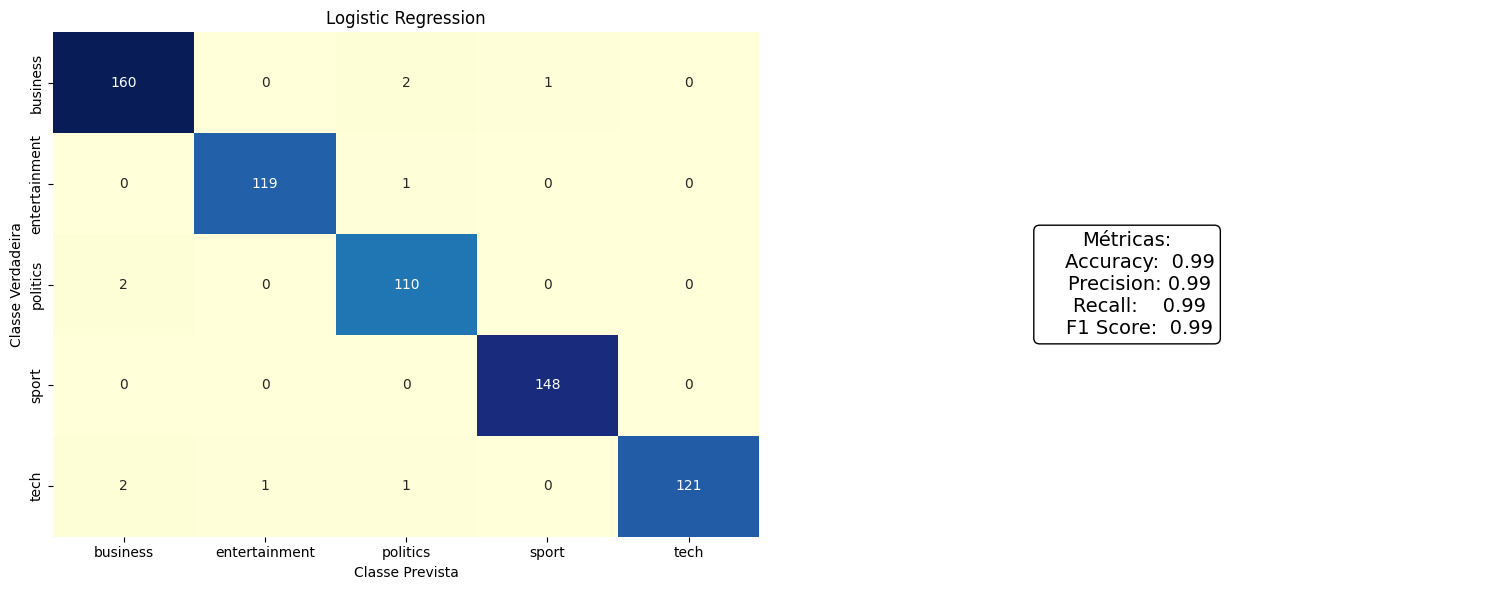

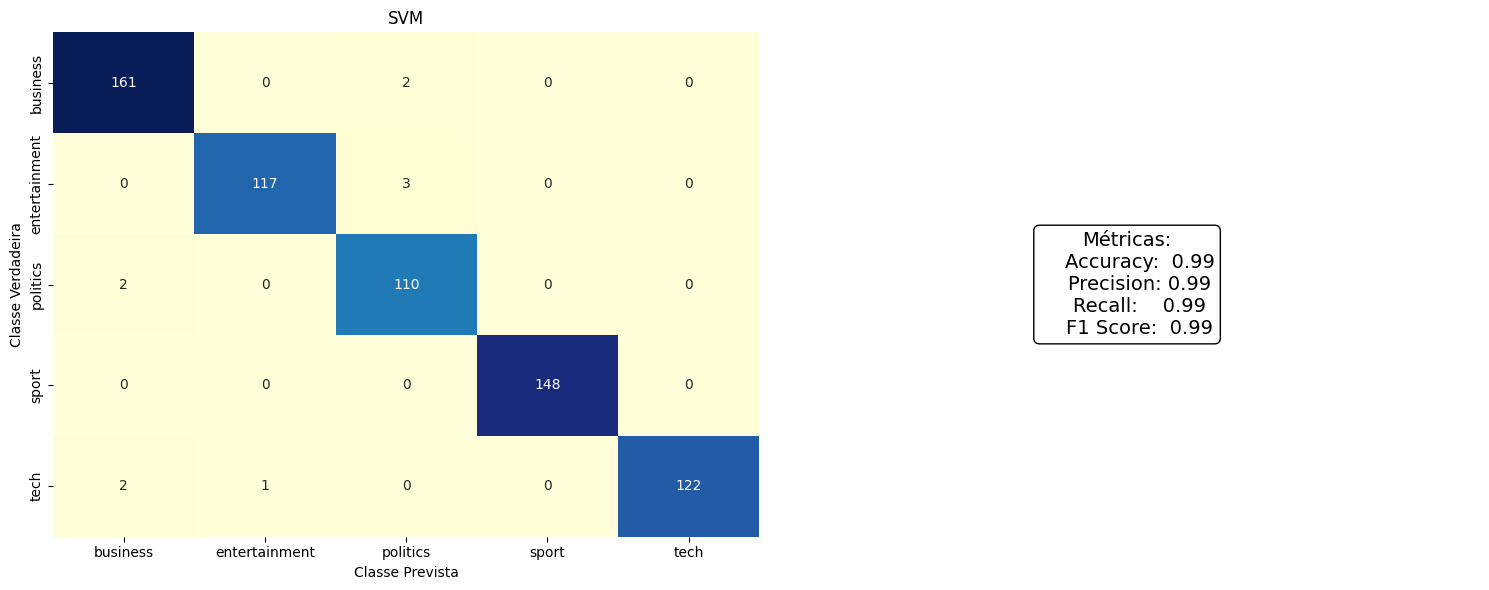

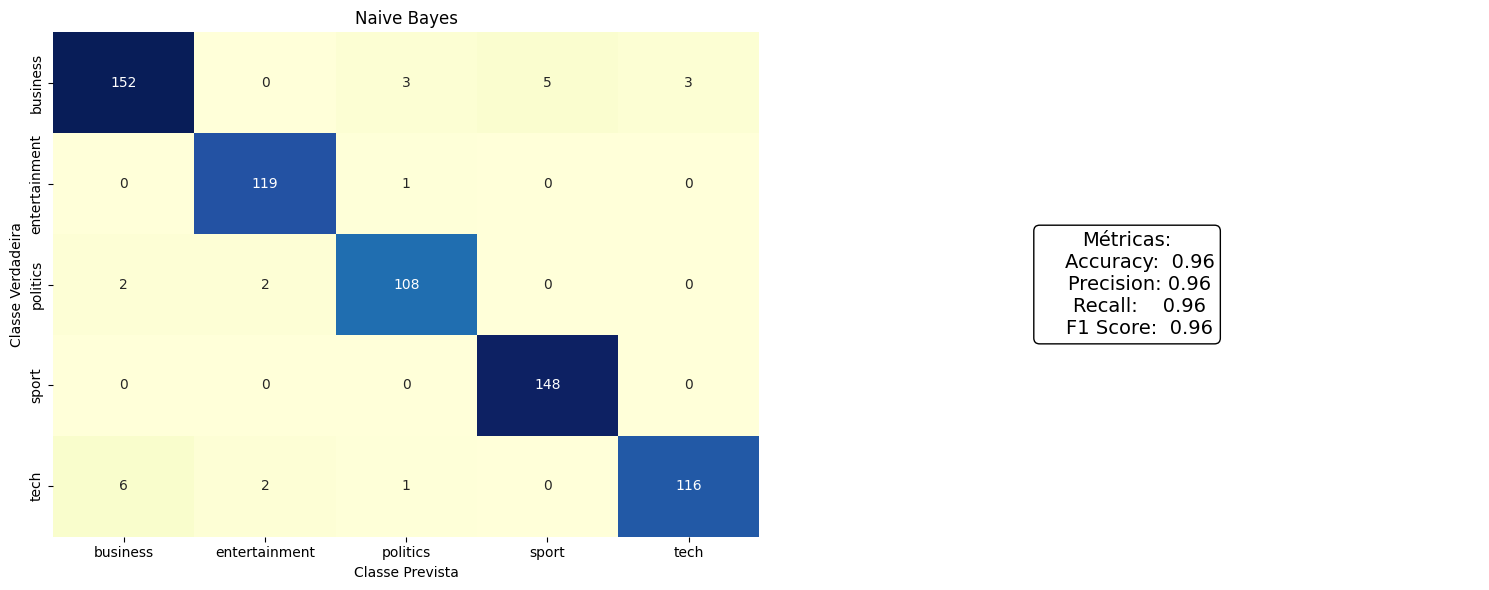

In [35]:
def metrics_describe(model, model_name):
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="weighted")
    recall = recall_score(y_test, y_pred, average="weighted")
    f1 = f1_score(y_test, y_pred, average="weighted")
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))  # 1x2 grid
    
    # Classes
    classes = model.classes_
    
    # Matriz de Confusão
    sns.heatmap(conf_matrix, annot=True, cmap="YlGnBu", fmt="d", cbar=False, ax=ax1, 
                xticklabels=classes, yticklabels=classes)
    ax1.set_title(f'{model_name}')
    ax1.set_xlabel('Classe Prevista')
    ax1.set_ylabel('Classe Verdadeira')
    
    # Métricas 
    metrics_text = f"""Métricas:
    Accuracy:  {accuracy:.2f}
    Precision: {precision:.2f}
    Recall:    {recall:.2f}
    F1 Score:  {f1:.2f}"""
    ax2.text(0.5, 0.5, metrics_text, fontsize=14, ha='center', va='center', 
             bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))
    ax2.axis('off')

    # Ajuste de layout
    plt.tight_layout()
    plt.show()

# O resto do código permanece o mesmo
def run_models():
    classifiers = {
        "Logistic Regression": LogisticRegression(),
        "SVM": LinearSVC(),
        "Naive Bayes": GaussianNB()
    }

    for model_name, model in classifiers.items():
        model.fit(X_train, y_train)
        metrics_describe(model, model_name)

# Chamando a função para rodar os modelos
run_models()